# Evaluate expert annotations on large PBMC panel

We aim to compare expert annotations on the same analysis task and compare their performance with one another to determine interrater variability. Here in this notebook, we harmonize the labels of each submission.   

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import datetime
#import pytometry as pm
import sklearn.metrics 
from upsetplot import plot, UpSet

import os

sc.logging.print_versions()
sc.settings.verbosity = 3 

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
asciitree           NA
asttokens           NA
backcall            0.2.0
cffi                1.15.1
cloudpickle         2.0.0
colorama            0.4.5
cupy                9.6.0
cupy_backends       NA
cupyx               NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2023.2.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           0.9.1
fasteners           0.17.3
fastrlock           0.8
google              NA
h5py                3.1.0
ipykernel           6.15.1
ipython_genutils    0.2.0
ipywidgets          7.7.1
jedi                0.18.1
jinja2              3.1.2
joblib              1.1.0
jupyter_server      1.18.1
kiwisolver          1.4.4
llvmlite            0.38.1
markupsafe          2.1.1
matplotlib          3.5.3
mpl_toolkits        NA
msgpack             1.0.3
nats

In [2]:
sc.settings.figdir = './../figures/' 

Add date.

In [3]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [4]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 80))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,10))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Introduction

In this notebook, we annotate flow data of an HIV study conducted at the DZNE by Anna Aschenbrenner and Lorenzo Bonaguro. 
We employ the following steps:
1. Load mannual gatings from several experts
2. Harmonize the labels
2. Compare manual gatings
3. Compare cell type labels of gating and clustering

# Read data

In [5]:
os.getcwd()

'/groups/NovaSeq-01/bioinformatics/users/buettnerm/convex_gating/notebooks'

In [6]:
data_path = './../data/Convex_gating_test_MB/'

In [7]:
adata_con = sc.read(data_path + 'anndata/' + 'HIV_data_concatenated.h5ad')

In [8]:
adata_con

AnnData object with n_obs × n_vars = 1444540 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'batch'
    var: 'channel', 'marker', 'signal_type'
    uns: 'meta'
    layers: 'original'

In [9]:
adata = sc.read(data_path + 'anndata/' + 'HIV_data_annotated_final.h5ad')

In [10]:
adata

AnnData object with n_obs × n_vars = 1142610 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'gate_root', 'gate_PBMC', 'gate_Single Cells', 'gate_Living', 'gate_B cells', 'gate_B cells (no class switch)', 'gate_B cells (switched memory)', 'gate_Living--others', 'gate_NK cells', 'gate_CD16high NK', 'gate_NK Immature', 'gate_NK Mature', 'gate_CD16low NK', 'gate_Living--others--others', 'gate_CD16 Monos', 'gate_Conv. Monos', 'gate_Int. Monos', 'gate_others--others--others', 'gate_cDCs', 'gate_pDCs', 'gate_Pre-DCs', 'gate_Living--T cells', 'gate_NKT', 'gate_CD4+NKT', 'gate_CD8+NKT', 'gate_otherNKT', 'gate_T cells--T cells', 'gate_CD4+ T cells', 'gate_CM CD4', 'gate_Eff. CD4', 'gate_Naive CD4', 'gate_PD1+ CD4 T cells', 'gate_TD CD4', 'gate_CD8+T cells', 'gate_CM CD8', 'gate_Eff. CD8', 'gate_Naive CD8', 'gate_TD CD8', 'batch', 'louvain', 'cluster cell_type_lvl_1', 'cluster cell_type_lvl_2'
    var: 'channel', 'marker', 'signal_type', 'channel_tmp'
    un

## Check sample order

Examine concatenation of files.

In [11]:
adata.obs.head()

,sample,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,Time,gate_root,gate_PBMC,...,gate_TD CD4,gate_CD8+T cells,gate_CM CD8,gate_Eff. CD8,gate_Naive CD8,gate_TD CD8,batch,louvain,cluster cell_type_lvl_1,cluster cell_type_lvl_2
1-1-0,NL01,39066.539062,33034.617188,105736.390625,15460.805664,13838.971680,67259.578125,2.113320,1,1,...,0,1,0,0,1,0,0,14,T cell,CD8+ T cell
2-1-0,NL01,85395.164062,71365.500000,117848.234375,36374.070312,32864.390625,79241.500000,2.334496,1,1,...,0,0,0,0,0,0,0,19,NK cell,NK cell
4-1-0,NL01,88837.500000,67739.335938,121593.328125,24809.623047,22744.226562,73066.046875,4.257128,1,1,...,0,0,0,0,0,0,0,18,NK cell,NK cell
5-1-0,NL01,75194.882812,61653.195312,117480.304688,30297.261719,27589.791016,78861.718750,4.548913,1,1,...,0,1,0,0,0,1,0,11,T cell,CD8+ T cell
6-1-0,NL01,40374.406250,30808.466797,109770.382812,29495.583984,23746.759766,80562.273438,4.808688,1,1,...,0,1,0,0,0,1,0,11,T cell,CD8+ T cell


In [12]:
for sample in adata.obs['sample'].cat.categories:
    print(sample)
    print(adata[adata.obs['sample']==sample].obs_names[:10])

NL01
Index(['1-1-0', '2-1-0', '4-1-0', '5-1-0', '6-1-0', '7-1-0', '8-1-0', '9-1-0',
       '10-1-0', '13-1-0'],
      dtype='object')
NL03
Index(['0-0-1', '2-0-1', '5-0-1', '6-0-1', '7-0-1', '8-0-1', '9-0-1', '10-0-1',
       '11-0-1', '12-0-1'],
      dtype='object')
NL05
Index(['0-2-2', '1-2-2', '2-2-2', '3-2-2', '5-2-2', '6-2-2', '7-2-2', '8-2-2',
       '10-2-2', '11-2-2'],
      dtype='object')
NL07
Index(['0-3-3', '1-3-3', '2-3-3', '3-3-3', '4-3-3', '5-3-3', '6-3-3', '7-3-3',
       '8-3-3', '9-3-3'],
      dtype='object')
NL09
Index(['0-4-4', '1-4-4', '2-4-4', '3-4-4', '4-4-4', '5-4-4', '7-4-4', '9-4-4',
       '10-4-4', '11-4-4'],
      dtype='object')


In [13]:
for sample in adata_con.obs['sample'].cat.categories:
    print(sample)
    print(adata_con[adata_con.obs['sample']==sample].obs_names[:10])

NL01
Index(['0-1', '1-1', '2-1', '3-1', '4-1', '5-1', '6-1', '7-1', '8-1', '9-1'], dtype='object')
NL03
Index(['0-0', '1-0', '2-0', '3-0', '4-0', '5-0', '6-0', '7-0', '8-0', '9-0'], dtype='object')
NL05
Index(['0-2', '1-2', '2-2', '3-2', '4-2', '5-2', '6-2', '7-2', '8-2', '9-2'], dtype='object')
NL07
Index(['0-3', '1-3', '2-3', '3-3', '4-3', '5-3', '6-3', '7-3', '8-3', '9-3'], dtype='object')
NL09
Index(['0-4', '1-4', '2-4', '3-4', '4-4', '5-4', '6-4', '7-4', '8-4', '9-4'], dtype='object')


In [14]:
adata.obs_names = [idx[:-2] for idx in adata.obs_names]

The order of the samples matters. We have to swap NL01 and NL03 to be consistent with the manual gates (obs_names issue).

In [15]:
adatas = []
for sample_key in adata_con.obs['sample'].cat.categories:
    print(sample_key)
    adata_tmp = adata_con[adata_con.obs['sample']==sample_key].copy()
    adata_tmp.obs_names = [idx[:-2] for idx in adata_tmp.obs_names]
    adatas.append(adata_tmp)

NL01
NL03
NL05
NL07
NL09


In [16]:
adata_con = ann.AnnData.concatenate(*adatas, join = 'outer', uns_merge = 'unique')

/home/buettnerm/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [17]:
adata_con

AnnData object with n_obs × n_vars = 1444540 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'batch'
    var: 'channel', 'marker', 'signal_type'
    uns: 'meta'
    layers: 'original'

In [18]:
adata_con.obs['sample'] = adata_con.obs['sample'].astype('category')
for sample in adata_con.obs['sample'].cat.categories:
    print(sample)
    print(adata_con[adata_con.obs['sample']==sample].obs_names[:10])

NL01
Index(['0-0', '1-0', '2-0', '3-0', '4-0', '5-0', '6-0', '7-0', '8-0', '9-0'], dtype='object')
NL03
Index(['0-1', '1-1', '2-1', '3-1', '4-1', '5-1', '6-1', '7-1', '8-1', '9-1'], dtype='object')
NL05
Index(['0-2', '1-2', '2-2', '3-2', '4-2', '5-2', '6-2', '7-2', '8-2', '9-2'], dtype='object')
NL07
Index(['0-3', '1-3', '2-3', '3-3', '4-3', '5-3', '6-3', '7-3', '8-3', '9-3'], dtype='object')
NL09
Index(['0-4', '1-4', '2-4', '3-4', '4-4', '5-4', '6-4', '7-4', '8-4', '9-4'], dtype='object')


In [19]:
adatas = []
for sample_key in adata.obs['sample'].cat.categories:
    print(sample_key)
    adata_tmp = adata[adata.obs['sample']==sample_key].copy()
    adata_tmp.obs_names = [idx[:-2] for idx in adata_tmp.obs_names]
    adatas.append(adata_tmp)

NL01
NL03
NL05
NL07
NL09


In [21]:
adata = ann.AnnData.concatenate(*adatas, join = 'outer', uns_merge = 'unique')

In [22]:
adata.obs['sample'] = adata.obs['sample'].astype('category')
for sample in adata.obs['sample'].cat.categories:
    print(sample)
    print(adata[adata.obs['sample']==sample].obs_names[:10])

NL01
Index(['1-0', '2-0', '4-0', '5-0', '6-0', '7-0', '8-0', '9-0', '10-0', '13-0'], dtype='object')
NL03
Index(['0-1', '2-1', '5-1', '6-1', '7-1', '8-1', '9-1', '10-1', '11-1',
       '12-1'],
      dtype='object')
NL05
Index(['0-2', '1-2', '2-2', '3-2', '5-2', '6-2', '7-2', '8-2', '10-2', '11-2'], dtype='object')
NL07
Index(['0-3', '1-3', '2-3', '3-3', '4-3', '5-3', '6-3', '7-3', '8-3', '9-3'], dtype='object')
NL09
Index(['0-4', '1-4', '2-4', '3-4', '4-4', '5-4', '7-4', '9-4', '10-4', '11-4'], dtype='object')


Check sample size.

In [23]:
adata.obs['sample'].value_counts()

NL05    377311
NL03    268668
NL01    260743
NL09    160884
NL07     75004
Name: sample, dtype: int64

## Check cell type annotation

In [24]:
adata.obs['cluster cell_type_lvl_1'].value_counts()

T cell            649386
Monocyte          269402
NK cell           146300
B cell             37450
not annotated      21779
Dendritic cell     18293
Name: cluster cell_type_lvl_1, dtype: int64

In [25]:
adata.obs['cluster cell_type_lvl_1'].cat.categories

Index(['B cell', 'Dendritic cell', 'Monocyte', 'NK cell', 'T cell',
       'not annotated'],
      dtype='object')

In [26]:
adata.obs['cluster cell_type_lvl_2'].cat.categories

Index(['B cell', 'CD4+ T cell', 'CD8+ T cell', 'NK T cell', 'NK cell',
       'T cell', 'not annotated', 'cDC', 'pDC', 'Classical monocyte',
       'Intermediate monocyte', 'Non-classical monocyte'],
      dtype='object')

In [27]:
adata.obs['cluster cell_type_lvl_2'].value_counts()

CD4+ T cell               378953
Classical monocyte        224127
CD8+ T cell               211381
NK cell                   146300
T cell                     56269
B cell                     37450
Non-classical monocyte     31889
not annotated              21779
cDC                        14950
Intermediate monocyte      13386
pDC                         3343
NK T cell                   2783
Name: cluster cell_type_lvl_2, dtype: int64

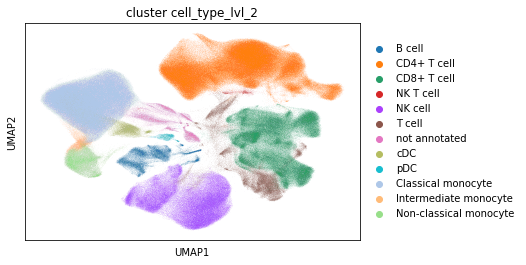

In [28]:
sc.pl.umap(adata, color='cluster cell_type_lvl_2')

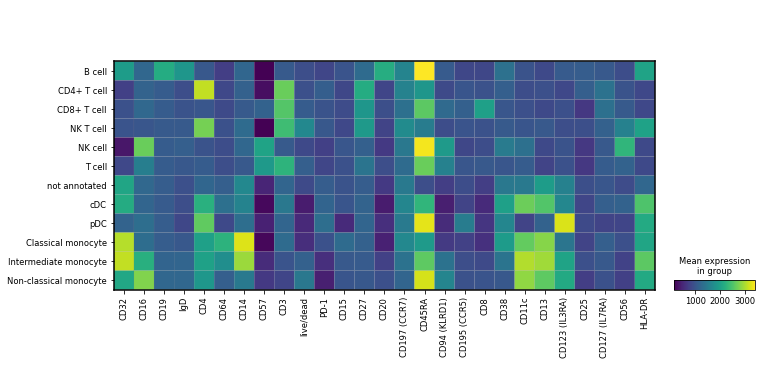

In [29]:
sc.pl.matrixplot(adata, groupby='cluster cell_type_lvl_2', var_names = adata.var_names)

Add the cell type info of the clustering to the concatenated anndata object for subsequent comparison with the manual gating.

In [30]:
adata_con.obs['cell debris'] = pd.Categorical(np.repeat('debris', adata_con.n_obs), 
                                        categories=[ 'debris', 'valid cell'])

In [31]:
filt_idx = [True if idx in adata.obs_names else False for idx in adata_con.obs_names]

In [32]:
lost_names = {}
lost_names2 = {}
for sample in adata_con.obs['sample'].cat.categories:
    print(sample)
    all_names = adata_con.obs_names[np.logical_and(adata_con.obs['sample']==sample, filt_idx) ]
    ann_names = adata.obs_names[adata.obs['sample']==sample]
    all_idx = [idx for idx in all_names if idx not in ann_names]
    not_idx = [idx for idx in ann_names if idx not in all_names]
    lost_names[sample] =  all_idx
    lost_names2[sample] = not_idx

NL01
NL03
NL05
NL07
NL09


In [33]:
for key in lost_names2.keys():
    print(len(lost_names[key]))
    print(len(lost_names2[key]))

0
0
0
0
0
0
0
0
0
0


In [34]:
adata_con.obs['cell debris'][filt_idx] = 'valid cell'

In [35]:
adata_con.obs['cell debris'].value_counts()

valid cell    1142610
debris         301930
Name: cell debris, dtype: int64

Add clustering-based cell type annotation.

In [36]:
adata_con.obs['cluster cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', adata_con.n_obs), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])
adata_con.obs['cluster cell type lvl 1'][filt_idx] = adata.obs['cluster cell_type_lvl_1']

adata_con.obs['cluster cell type lvl 2'] = pd.Categorical(np.repeat('not annotated', adata_con.n_obs), 
                                        categories=['B cell', 'CD4+ T cell', 'CD8+ T cell', 'NK T cell', 'NK cell',
       'T cell', 'not annotated', 'Classical monocyte',
       'Non-classical monocyte', 'Intermediate monocyte', 'cDC', 'pDC',
       ])
adata_con.obs['cluster cell type lvl 2'][filt_idx] = adata.obs['cluster cell_type_lvl_2']

# Reformat gate info

In order to compare the manual annotation to the clustering result, we aim to reformat the gate info. Notably, when we annotated clusters, we used a slightly different pre-processing of the cells (e.g. live/dead marker, singlet gate). Therefore, we end up with a slightly different set of cells for the clustering annotation. In order to compare Python-based annotation and manual gating, we do the comparison on the entire data set so that we can take all cells into account and minimize differences caused by different pre-processing steps. The clustering info is then added to the concatenated anndata file.

In [61]:
data_path = './../data/Convex_gating_test_MB/'

## Gold standard

Read gating information from FlowJo.

In [62]:
files_all = os.listdir(data_path)

Read gating information from FlowJo.

In [63]:
files_gate = [fileID for fileID in files_all if fileID.count('_gate_')>0]

In [64]:
gate_info = []
for fileID in files_gate: 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{data_path}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'Gold'
    gate_info.append(gate_df)

In [65]:
gate_df_gold = pd.concat(gate_info, ignore_index=True)
gate_df_gold.index = adata_con.obs_names

In [66]:
gate_df_gold.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
PBMC,0,1,1,1,1
Single Cells,0,1,1,1,1
Living,0,1,1,1,1
B cells,0,0,0,0,0
B cells (no class switch),0,0,0,0,0
B cells (switched memory),0,0,0,0,0
Living/others,0,0,1,1,1
NK cells,0,0,1,0,1


Add a debris/cell distinction, using the live/dead and singlets filter.

In [67]:
gate_df_gold['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_gold)), 
                                        categories=[ 'debris', 'valid cell'])

In [68]:
live_cell_idx = gate_df_gold['Living']>0
singlet_idx = gate_df_gold['Single Cells']>0

In [69]:
gate_df_gold['manual cell debris'][np.logical_and(live_cell_idx, singlet_idx)] = 'valid cell'

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs and cDCs. 

In [70]:
gate_df_gold['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_gold)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [71]:
b_cell_idx = gate_df_gold['B cells']>0
t_cell_idx = gate_df_gold['Living/T cells']>0
nk_cell_idx = gate_df_gold['NK cells']>0
monocyte_idx = np.sum(gate_df_gold[['CD16 Monos', 'Conv. Monos', 'Int. Monos'
                                ]], axis=1)>0
dc_idx = np.sum(gate_df_gold[['cDCs', 'pDCs', 'Pre-DCs'
                                ]], axis=1)>0


gate_df_gold['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_gold['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_gold['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_gold['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'
gate_df_gold['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'

In [72]:
gate_df_gold['manual cell type lvl 1'].value_counts()

T cell            655908
Monocyte          374656
not annotated     195883
NK cell           153542
B cell             34150
Dendritic cell     30401
Name: manual cell type lvl 1, dtype: int64

In [73]:
gate_df_gold['manual cell type lvl 2'] = gate_df_gold['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [74]:
cd4t_cell_idx = gate_df_gold['CD4+ T cells']>0
cd8t_cell_idx = gate_df_gold['CD8+T cells']>0
nkt_cell_idx = gate_df_gold['NKT']>0
cmonocyte_idx = gate_df_gold['Conv. Monos']>0
imonocyte_idx = gate_df_gold['Int. Monos']>0
ncmonocyte_idx = gate_df_gold['CD16 Monos']>0
cdc_idx = gate_df_gold['cDCs']>0
pdc_idx = gate_df_gold['pDCs']>0


gate_df_gold['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_gold['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
gate_df_gold['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_gold['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_gold['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_gold['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'
gate_df_gold['manual cell type lvl 2'][pdc_idx] = 'pDC'
gate_df_gold['manual cell type lvl 2'][cdc_idx] = 'cDC'


gate_df_gold['manual cell type lvl 2'] = gate_df_gold['manual cell type lvl 2'].cat.remove_unused_categories()

In [75]:
gate_df_gold['manual cell type lvl 2'].value_counts()

CD4+ T cell               383229
Classical monocyte        313156
not annotated             195883
CD8+ T cell               187507
NK cell                   153542
T cell                     53051
Non-classical monocyte     35755
B cell                     34150
NKT cell                   32121
Intermediate monocyte      25745
cDC                        19291
pDC                         6439
Dendritic cell              4671
Name: manual cell type lvl 2, dtype: int64

Save gates to csv file.

In [76]:
gate_df_gold.to_csv(data_path + 'gate_df_gold_final.csv' )

## Add gating results from other experts

We have included the original authors' gating as the "gold standard" of the data when we loaded the entire dataset. The reason is that the exported csv files cannot be directly matched to the anndata files, because they do not employ the same indexing. We therefore match to the concatenated anndata file and subset subsequently.  

In [191]:
gate_data_p1 = os.path.join(data_path, 'gating_experiment/P1/')
gate_data_p2 = os.path.join(data_path, 'gating_experiment/P2/')
gate_data_p3 = os.path.join(data_path, 'gating_experiment/P3/')
gate_data_p4 = os.path.join(data_path, 'gating_experiment/P4/')
gate_data_p5 = os.path.join(data_path, 'gating_experiment/P5/')
gate_data_p6 = os.path.join(data_path, 'gating_experiment/P6/')
gate_data_p71 = os.path.join(data_path, 'gating_experiment/P71/')
gate_data_p72 = os.path.join(data_path, 'gating_experiment/P72/')
gate_data_p73 = os.path.join(data_path, 'gating_experiment/P73/')
gate_data_p74 = os.path.join(data_path, 'gating_experiment/P74/')

### Submission of P1

In [78]:
files_p1 = os.listdir(gate_data_p1)

In [79]:
files = [fileID for fileID in files_p1 if fileID.endswith('.csv')]

Read gating information from FlowJo.

In [80]:
files_gate = [fileID for fileID in files_p1 if fileID.count('gate_19')>0]

In [82]:
gate_info = []
for fileID in files_gate: 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{gate_data_p1}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'P1'
    gate_info.append(gate_df)

In [83]:
gate_df_P1 = pd.concat(gate_info, ignore_index=True)
gate_df_P1.index = adata_con.obs_names

In [84]:
gate_df_P1.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
Lymphocytes,0,1,1,1,1
singlets,0,1,1,1,1
live_dead,0,1,1,1,1
DCs,0,0,1,0,1
mDCs,0,0,0,0,0
pDCs,0,0,0,0,0
preDCs,0,0,0,0,0
lymphocytes,0,1,1,0,1


Add a debris/cell distinction, using the live/dead and singlets filter.

In [85]:
gate_df_P1['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_P1)), 
                                        categories=[ 'debris', 'valid cell'])

In [86]:
live_cell_idx = gate_df_P1['live_dead']>0
singlet_idx = gate_df_P1['singlets']>0

In [87]:
gate_df_P1['manual cell debris'][np.logical_and(live_cell_idx, singlet_idx)] = 'valid cell'

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs and cDCs. 

In [88]:
gate_df_P1['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_P1)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [89]:
b_cell_idx = gate_df_P1['B-cells']>0
t_cell_idx = gate_df_P1['T-cells']>0
nk_cell_idx = gate_df_P1['NK cells']>0
monocyte_idx = gate_df_P1['monocytes']>0
dc_idx = dc_idx = np.sum(gate_df_P1[['mDCs', 'pDCs', 'preDCs']], axis=1)>0


gate_df_P1['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_P1['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_P1['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_P1['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'
gate_df_P1['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'

In [90]:
gate_df_P1['manual cell type lvl 1'].value_counts()

T cell            634490
Monocyte          295317
not annotated     285843
NK cell           149654
Dendritic cell     47159
B cell             32077
Name: manual cell type lvl 1, dtype: int64

In [91]:
gate_df_P1['manual cell type lvl 2'] = gate_df_P1['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [92]:
cd4t_cell_idx = gate_df_P1['CD4+']>0
cd8t_cell_idx = gate_df_P1['CD8+']>0
#nkt_cell_idx = adata.obs['gate_NKT']>0
cmonocyte_idx = gate_df_P1['classical monocytes']>0
imonocyte_idx = gate_df_P1['intermediate monocytes']>0
ncmonocyte_idx = gate_df_P1['non-classical monocytes']>0
cdc_idx = gate_df_P1['mDCs']>0 #typo
pdc_idx = gate_df_P1['pDCs']>0



gate_df_P1['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_P1['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
#gate_df_P1['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_P1['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_P1['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_P1['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'
gate_df_P1['manual cell type lvl 2'][cdc_idx] = 'cDC'
gate_df_P1['manual cell type lvl 2'][pdc_idx] = 'pDC'



In [93]:
gate_df_P1['manual cell type lvl 2'].value_counts()

CD4+ T cell               374581
not annotated             285843
Classical monocyte        250006
CD8+ T cell               197478
NK cell                   149518
T cell                     62567
cDC                        36251
B cell                     32077
Monocyte                   22174
Intermediate monocyte      18933
pDC                         6693
Dendritic cell              4214
Non-classical monocyte      4205
NKT cell                       0
Name: manual cell type lvl 2, dtype: int64

Save to file.

In [94]:
gate_df_P1.to_csv(gate_data_p1+'gate_df_P1.csv')

### Submission of P2

In [97]:
files_p2 = os.listdir(gate_data_p2)

In [99]:
files = [fileID for fileID in files_p2 if fileID.endswith('.csv')]

Read gating information from FlowJo.

In [103]:
files_gate = [fileID for fileID in files_p2 if fileID.count('45_gate_')>0]

In [106]:
gate_info = []
for fileID in np.unique(files_gate): 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{gate_data_p2}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'P2'
    gate_info.append(gate_df)

In [107]:
gate_df_P2 = pd.concat(gate_info, ignore_index=True)
gate_df_P2.index = adata_con.obs_names

In [108]:
gate_df_P2.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
Lymphocytes,0,1,1,0,1
Lymphocytes/Single Cells,0,1,1,0,1
B cells,0,0,0,0,0
CD3-,0,0,1,0,1
NK cells,0,0,1,0,1
Live T cells,0,1,0,0,0
CD4+ T cells,0,0,0,0,0
CD8+ T cells,0,0,0,0,0


Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs, cDCs and pre-DCs. 

In [109]:
gate_df_P2['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_P2)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [110]:
b_cell_idx = gate_df_P2['B cells']>0
t_cell_idx = gate_df_P2['Live T cells']>0
nk_cell_idx = gate_df_P2['NK cells']>0
monocyte_idx = np.sum(gate_df_P2[['Non-classical monocytes', 
                                  'Intermediate monocytes', 
                                  'Classical monocytes']], axis=1)>0
dc_idx = dc_idx = np.sum(gate_df_P2[['cDCs', 'pDCs', 'pre-DCs']], axis=1)>0


gate_df_P2['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_P2['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_P2['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_P2['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'
gate_df_P2['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'

In [111]:
gate_df_P2['manual cell type lvl 1'].value_counts()

T cell            600624
not annotated     401546
Monocyte          260116
NK cell           143441
B cell             30010
Dendritic cell      8803
Name: manual cell type lvl 1, dtype: int64

In [112]:
gate_df_P2['manual cell type lvl 2'] = gate_df_P2['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [113]:
cd4t_cell_idx = gate_df_P2['CD4+ T cells']>0
cd8t_cell_idx = gate_df_P2['CD8+ T cells']>0
nkt_cell_idx = gate_df_P2['NKT cells']>0
cmonocyte_idx = gate_df_P2['Classical monocytes']>0
imonocyte_idx = gate_df_P2['Intermediate monocytes']>0
ncmonocyte_idx = gate_df_P2['Non-classical monocytes']>0
cdc_idx = gate_df_P2['cDCs']>0
pdc_idx = gate_df_P2['pDCs']>0


gate_df_P2['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_P2['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
gate_df_P2['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_P2['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_P2['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_P2['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'
gate_df_P2['manual cell type lvl 2'][cdc_idx] = 'cDC'
gate_df_P2['manual cell type lvl 2'][pdc_idx] = 'pDC'

gate_df_P2['manual cell type lvl 2'] = gate_df_P2['manual cell type lvl 2'].cat.remove_unused_categories()

In [114]:
gate_df_P2['manual cell type lvl 2'].value_counts()

not annotated             401546
CD4+ T cell               355260
Classical monocyte        230684
CD8+ T cell               154333
NK cell                   143441
T cell                     59560
NKT cell                   31471
B cell                     30010
Intermediate monocyte      18196
Non-classical monocyte     11646
cDC                         5559
pDC                         2196
Dendritic cell               638
Name: manual cell type lvl 2, dtype: int64

Add a debris/cell distinction, using the live/dead and singlets filter.

In [115]:
gate_df_P2['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_P2)), 
                                        categories=[ 'debris', 'valid cell'])

In this gating info, there is little information on the pre-processing. We therefore take all non-Lymphocytes and non-PBMCs as 'debris'.

In [116]:
live_cell_idx = np.sum(gate_df_P2[['Live cells', 'Lymphocytes', 'PBMCs']], axis = 1)>0

In [117]:
np.sum(live_cell_idx)

1220034

In [120]:
gate_df_P2['manual cell debris'][live_cell_idx] = 'valid cell'

In [121]:
pd.crosstab(gate_df_P2['manual cell debris'],
            [gate_df_P2['manual cell type lvl 2'], 
            
                                  ] )

manual cell type lvl 2,B cell,T cell,NK cell,Dendritic cell,not annotated,CD4+ T cell,CD8+ T cell,NKT cell,Classical monocyte,Intermediate monocyte,Non-classical monocyte,pDC,cDC
manual cell debris,,,,,,,,,,,,,
debris,0,0,0,0,224506,0,0,0,0,0,0,0,0
valid cell,30010,59560,143441,638,177040,355260,154333,31471,230684,18196,11646,2196,5559


Save to file.

In [122]:
gate_df_P2.to_csv(gate_data_p2+ 'gate_df_P2.csv')

### Submission of P3

In [123]:
files_p3 = os.listdir(gate_data_p3)

In [124]:
files = [fileID for fileID in files_p3 if fileID.endswith('.csv')]

Read gating information from FlowJo.

In [127]:
files_gate = [fileID for fileID in files_p3 if fileID.count('gate_19')>0]

In [128]:
gate_info = []
for fileID in files_gate: 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{gate_data_p3}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'P3'
    gate_info.append(gate_df)

In [129]:
gate_df_P3 = pd.concat(gate_info, ignore_index=True)
gate_df_P3.index = adata_con.obs_names

In [130]:
gate_df_P3.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
Cells,0,1,1,1,1
Single Cells,0,1,1,1,1
live cells,0,1,1,1,1
Lymphocytes,0,1,1,0,1
B cells,0,0,0,0,0
NK cells,0,0,1,0,1
NKT cells,0,0,0,0,0
T cells,0,1,0,0,0


In [131]:
pd.crosstab(gate_df_P3['sample'], [gate_df_P3['Cells'], #
                                   gate_df_P3['Single Cells'],
                                   gate_df_P3['live cells'],
                                 
                                  ] )

Cells             0     1               
Single Cells      0     0      1        
live cells        0     0      0       1
sample                                  
NL01          14946  3474   5142  302032
NL03          68306  5158  14102  297170
NL05          32579  6304  16737  399429
NL07           2064   594   1611   79121
NL09           7168  4452   2246  181905

Add a debris/cell distinction, using the live/dead and singlets filter.

In [132]:
gate_df_P3['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_P3)), 
                                        categories=[ 'debris', 'valid cell'])

In [133]:
live_cell_idx = gate_df_P3['live cells']>0
singlet_idx = gate_df_P3['Single Cells']>0

In [134]:
gate_df_P3['manual cell debris'][np.logical_and(live_cell_idx, singlet_idx)] = 'valid cell'

In [135]:
gate_df_P3['manual cell debris'].value_counts()

valid cell    1259657
debris         184883
Name: manual cell debris, dtype: int64

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs and cDCs. 

In [136]:
pd.crosstab(gate_df_P3['sample'], [gate_df_P3['live cells/Monocytes'], 
                                   gate_df_P3['Monocytes/Monocytes'], 
                                   gate_df_P3['Classical monocytes']
                                  ] )

live cells/Monocytes       0      1              
Monocytes/Monocytes        0      0      1       
Classical monocytes        0      0      0      1
sample                                           
NL01                  214878  46534  14852  49330
NL03                  314031   5198  13740  51767
NL05                  368404  15003  13535  58107
NL07                   66370   2223   2109  12688
NL09                  129137   6364  13130  47140

In [137]:
gate_df_P3['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_P3)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [138]:
b_cell_idx = gate_df_P3['B cells']>0
t_cell_idx = gate_df_P3['T cells']>0
nk_cell_idx = gate_df_P3['NK cells']>0
monocyte_idx = gate_df_P3['Monocytes/Monocytes']>0
dc_idx = dc_idx = np.sum(gate_df_P3[['cDCs', 'pDC', 
                                    ]], axis=1)>0

gate_df_P3['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'
gate_df_P3['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_P3['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_P3['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_P3['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'


In [139]:
gate_df_P3['manual cell type lvl 1'].value_counts()

T cell            627268
not annotated     299563
Monocyte          276398
NK cell           150302
Dendritic cell     59091
B cell             31918
Name: manual cell type lvl 1, dtype: int64

In [140]:
gate_df_P3['manual cell type lvl 2'] = gate_df_P3['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [141]:
cd4t_cell_idx = gate_df_P3['CD4+ T cells']>0
cd8t_cell_idx = gate_df_P3['CD8+ T cells']>0
nkt_cell_idx = gate_df_P3['NKT cells']>0
cmonocyte_idx = gate_df_P3['Classical monocytes']>0
imonocyte_idx = gate_df_P3['Intermediate monocytes']>0
ncmonocyte_idx = gate_df_P3['Non-classical monocytes']>0
cdc_idx = gate_df_P3['cDCs']>0
pdc_idx = gate_df_P3['pDC']>0



gate_df_P3['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_P3['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
gate_df_P3['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_P3['manual cell type lvl 2'][cdc_idx] = 'cDC'
gate_df_P3['manual cell type lvl 2'][pdc_idx] = 'pDC'
gate_df_P3['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_P3['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_P3['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'


#gate_df_P1['manual cell type lvl 2'] = gate_df_P1['manual cell type lvl 2'].cat.remove_unused_categories()

In [142]:
gate_df_P3['manual cell type lvl 2'].value_counts()

CD4+ T cell               370552
not annotated             299540
Classical monocyte        218759
CD8+ T cell               177240
NK cell                   150282
cDC                        71460
T cell                     52327
B cell                     31918
NKT cell                   27192
Intermediate monocyte      19479
Non-classical monocyte     17276
Monocyte                    5421
pDC                         3094
Dendritic cell                 0
Name: manual cell type lvl 2, dtype: int64

Save to file.

In [144]:
gate_df_P3.to_csv(gate_data_p3+ 'gate_df_P3.csv')

### Submission of P4

In [145]:
files_p4 = os.listdir(gate_data_p4)

In [146]:
files = [fileID for fileID in files_p4 if fileID.endswith('.csv')]

Read gating information from FlowJo.

In [148]:
files_gate = [fileID for fileID in files_p4 if fileID.count('gate_19')>0]

In [150]:
gate_info = []
for fileID in files_gate: 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{gate_data_p4}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'P4'
    gate_info.append(gate_df)

In [151]:
gate_df_P4 = pd.concat(gate_info, ignore_index=True)
gate_df_P4.index = adata_con.obs_names

In [152]:
gate_df_P4.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
Leukocytes,0,0,1,1,1
Single Cells,0,0,1,1,1
"FSC-A, live_dead subset",0,0,1,1,1
B cells,0,0,0,0,0
Basophil,0,0,0,0,0
Myeloid,0,0,0,1,0
classical Monocytes,0,0,0,1,0
DCs,0,0,0,1,0


In [153]:
gate_df_P4.columns

Index(['Time', 'root', 'Leukocytes', 'Single Cells', 'FSC-A, live_dead subset',
       'B cells', 'Basophil', 'Myeloid', 'classical Monocytes', 'DCs', 'cDC',
       'cDC1', 'cDC2', 'intermediate Monocytes', 'Non-classical Monocytes',
       'pre-DC', 'Q4: CD14- , CD16-', 'NK', 'NKT', 'pDC', 'Q2: CD3+ , CD19+',
       'Q4: CD3- , CD19-', 'T cells', 'CD4+', 'CD8+', 'Q2: CD4+ , CD8+',
       'Q4: CD4- , CD8-', 'sample', 'expert'],
      dtype='object')

In [154]:
pd.crosstab(gate_df_P4['sample'], [gate_df_P4['Single Cells'],
                                   gate_df_P4['FSC-A, live_dead subset'],
                                 
                                  ] )

Single Cells                  0      1        
FSC-A, live_dead subset       0      0       1
sample                                        
NL01                      55269  25874  244451
NL03                     126113  26451  232172
NL05                      93877  30121  331051
NL07                       9328   6697   67365
NL09                      35105  19343  141323

Add a debris/cell distinction, using the live/dead and singlets filter.

In [155]:
gate_df_P4['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_P4)), 
                                        categories=[ 'debris', 'valid cell'])

In [156]:
live_cell_idx = gate_df_P4['FSC-A, live_dead subset']>0
singlet_idx = gate_df_P4['Single Cells']>0

In [157]:
gate_df_P4['manual cell debris'][np.logical_and(live_cell_idx, singlet_idx)] = 'valid cell'

In [158]:
gate_df_P4['manual cell debris'].value_counts()

valid cell    1016362
debris         428178
Name: manual cell debris, dtype: int64

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs, cDCs and pre-DCs. 

In [159]:
pd.crosstab(gate_df_P4['sample'], [gate_df_P4['DCs'], 
                                   gate_df_P4['cDC'], 
                                   gate_df_P4['cDC1'],
                                   gate_df_P4['cDC2'],
                                   gate_df_P4['pDC'],
                                   
                                  ] )

DCs          0            1                        
cDC          0            0     1                  
cDC1         0            0     0              1   
cDC2         0            0     0         1    0   
pDC          0     1      0  1  0  1      0    0  1
sample                                             
NL01    254107   798  41130  7  1  0  29463   88  0
NL03    344068  1632  35114  2  0  0   3897   23  0
NL05    405047  1875  37851  3  9  0  10102  161  1
NL07     72218   278   7629  0  1  1   3253   10  0
NL09    157290   574  30065  1  2  0   7762   77  0

In [160]:
gate_df_P4['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_P4)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [161]:
b_cell_idx = gate_df_P4['B cells']>0
t_cell_idx = gate_df_P4['T cells']>0
nk_cell_idx = gate_df_P4['NK']>0
monocyte_idx = np.sum(gate_df_P4[['classical Monocytes', 'intermediate Monocytes', 'Non-classical Monocytes'
                                    ]], axis=1)>0
dc_idx = np.sum(gate_df_P4[['DCs', 'cDC',
        'pre-DC', 'pDC'
                                    ]], axis=1)>0

gate_df_P4['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'
gate_df_P4['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_P4['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_P4['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_P4['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'


In [162]:
gate_df_P4['manual cell type lvl 1'].value_counts()

T cell            569033
not annotated     534971
Monocyte          214051
NK cell            87297
B cell             29995
Dendritic cell      9193
Name: manual cell type lvl 1, dtype: int64

In [163]:
gate_df_P4['manual cell type lvl 2'] = gate_df_P4['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [164]:
cd4t_cell_idx = gate_df_P4['CD4+']>0
cd8t_cell_idx = gate_df_P4['CD8+']>0
nkt_cell_idx = gate_df_P4['NKT']>0
cmonocyte_idx = gate_df_P4['classical Monocytes']>0
imonocyte_idx = gate_df_P4['intermediate Monocytes']>0
ncmonocyte_idx = gate_df_P4['Non-classical Monocytes']>0
cdc_idx = gate_df_P4['cDC']>0
pdc_idx = gate_df_P4['pDC']>0


gate_df_P4['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_P4['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
gate_df_P4['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_P4['manual cell type lvl 2'][cdc_idx] = 'cDC'
gate_df_P4['manual cell type lvl 2'][pdc_idx] = 'pDC'
gate_df_P4['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_P4['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_P4['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'


#gate_df_P1['manual cell type lvl 2'] = gate_df_P1['manual cell type lvl 2'].cat.remove_unused_categories()

In [165]:
gate_df_P4['manual cell type lvl 2'].value_counts()

not annotated             534942
CD4+ T cell               314816
Classical monocyte        193620
NKT cell                  123958
CD8+ T cell               106378
NK cell                    87290
B cell                     29987
T cell                     23909
Intermediate monocyte      12833
Non-classical monocyte      7598
pDC                         4805
Dendritic cell              4170
cDC                          234
Monocyte                       0
Name: manual cell type lvl 2, dtype: int64

Save to file.

In [166]:
gate_df_P4.to_csv(gate_data_p4+ 'gate_df_P4.csv')

### Submission of P5

In [167]:
files_p5 = os.listdir(gate_data_p5)

In [168]:
files = [fileID for fileID in files_p5 if fileID.endswith('.csv')]

Read gating information from FlowJo.

In [169]:
files_gate = [fileID for fileID in files_p5 if fileID.count('gate_19')>0]

In [172]:
gate_info = []
for fileID in files_gate: 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{gate_data_p5}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'P5'
    gate_info.append(gate_df)

In [173]:
gate_df_P5 = pd.concat(gate_info, ignore_index=True)
gate_df_P5.index = adata_con.obs_names

In [174]:
gate_df_P5.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
Cells,0,1,1,1,1
Cells/Single Cells,0,1,1,1,1
Single Cells/Single Cells,0,1,1,1,1
living,0,1,1,1,1
T cells,0,1,0,0,0
conventional T cells,0,1,0,0,0
CD4 T cells,0,0,0,0,0
Tconv,0,0,0,0,0


In [176]:
pd.crosstab(gate_df_P5['sample'], [gate_df_P5['Cells'],
                                   gate_df_P5['Cells/Single Cells'],
                                   gate_df_P5['Single Cells/Single Cells'],
                                   gate_df_P5['living'],
                                  
                                  ] )

Cells                          0     1                    
Cells/Single Cells             0     0     1              
Single Cells/Single Cells      0     0     0     1        
living                         0     0     0     0       1
sample                                                    
NL01                       19251  2304  1488  4678  297873
NL03                       74594  2840  4349  7488  295465
NL05                       39273  3320  6836  9612  396008
NL07                        2783   254   659  1189   78505
NL09                       11959   789  1215  2815  178993

Add a debris/cell distinction, using the live/dead and singlets filter.

In [177]:
gate_df_P5['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_P5)), 
                                        categories=[ 'debris', 'valid cell'])

In [178]:
live_cell_idx = gate_df_P5['living']>0
singlet_idx = gate_df_P5['Single Cells/Single Cells']>0

In [179]:
gate_df_P5['manual cell debris'][np.logical_and(live_cell_idx, singlet_idx)] = 'valid cell'

In [180]:
gate_df_P5['manual cell debris'].value_counts()

valid cell    1246844
debris         197696
Name: manual cell debris, dtype: int64

In [181]:
gate_df_P5.columns

Index(['Time', 'root', 'Cells', 'Cells/Single Cells',
       'Single Cells/Single Cells', 'living', 'T cells',
       'conventional T cells', 'CD4 T cells', 'Tconv', 'Treg', 'CD8 T cells',
       'DN T cells', 'NKT cells', 'CD19+ B cells', 'B cells', 'non-TB cells',
       'DCs', 'cDC', 'pDC', 'Monocytes', 'classical monocytes',
       'intermediate monocytes', 'non-classical monocytes', 'others',
       'Basophils', 'NK cells', 'sample', 'expert', 'manual cell debris'],
      dtype='object')

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs, cDCs and pre-DCs. 

In [182]:
pd.crosstab(gate_df_P5['sample'], [gate_df_P5['DCs'], 
                                   gate_df_P5['cDC'], 
                                   gate_df_P5['pDC'],
                                   
                                  
                                   
                                  ] )

DCs          0     1             
cDC          0     0            1
pDC          0     0     1      0
sample                           
NL01    314373  1562   938   8721
NL03    368215  3525  2133  10863
NL05    439773  2969  2412   9895
NL07     80949   445   364   1632
NL09    181989  1018   701  12063

In [183]:
gate_df_P5['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_P5)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [184]:
b_cell_idx = gate_df_P5['B cells']>0
t_cell_idx = gate_df_P5['T cells']>0
nk_cell_idx = gate_df_P5['NK cells']>0
monocyte_idx = gate_df_P5['Monocytes']>0
dc_idx = np.sum(gate_df_P5[['DCs', 'cDC','pDC'
                                    ]], axis=1)>0

gate_df_P5['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'
gate_df_P5['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_P5['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_P5['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_P5['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'


In [185]:
gate_df_P5['manual cell type lvl 1'].value_counts()

T cell            639280
Monocyte          327071
not annotated     242985
NK cell           144809
Dendritic cell     59241
B cell             31154
Name: manual cell type lvl 1, dtype: int64

In [186]:
gate_df_P5['manual cell type lvl 2'] = gate_df_P5['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [187]:
cd4t_cell_idx = gate_df_P5['CD4 T cells']>0
cd8t_cell_idx = gate_df_P5['CD8 T cells']>0
nkt_cell_idx = gate_df_P5['NKT cells']>0
cmonocyte_idx = gate_df_P5['classical monocytes']>0
imonocyte_idx = gate_df_P5['intermediate monocytes']>0
ncmonocyte_idx = gate_df_P5['non-classical monocytes']>0
cdc_idx = gate_df_P5['cDC']>0
pdc_idx = gate_df_P5['pDC']>0



gate_df_P5['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_P5['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
gate_df_P5['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_P5['manual cell type lvl 2'][cdc_idx] = 'cDC'
gate_df_P5['manual cell type lvl 2'][pdc_idx] = 'pDC'
gate_df_P5['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_P5['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_P5['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'


In [188]:
gate_df_P5['manual cell type lvl 2'].value_counts()

CD4+ T cell               375310
Classical monocyte        292584
not annotated             242985
CD8+ T cell               181662
NK cell                   144809
T cell                     47358
cDC                        43174
NKT cell                   34950
B cell                     31154
Non-classical monocyte     16208
Monocyte                   10802
Dendritic cell              9519
Intermediate monocyte       7477
pDC                         6548
Name: manual cell type lvl 2, dtype: int64

Save to file.

In [189]:
gate_df_P5.to_csv(gate_data_p5+ 'gate_df_P5.csv')

### Submission of P6

In [192]:
files_p6 = os.listdir(gate_data_p6)

In [193]:
files = [fileID for fileID in files_p6 if fileID.endswith('.csv')]

Read gating information from FlowJo.

In [195]:
files_gate = [fileID for fileID in files_p6 if fileID.count('gate_19')>0]

In [197]:
gate_info = []
for fileID in files_gate: 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{gate_data_p6}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'P6'
    gate_info.append(gate_df)

In [198]:
gate_df_P6 = pd.concat(gate_info, ignore_index=True)
gate_df_P6.index = adata_con.obs_names

In [199]:
gate_df_P6.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
live_dead cells,1,1,1,1,1
CD45+,0,1,1,1,1
Cells,0,1,1,1,1
Single Cells1,0,1,1,1,1
Single Cells2,0,1,1,1,1
B cells,0,0,0,0,0
CD3- CD19- cells,0,0,1,1,1
NK cells,0,0,1,0,1


In [200]:
gate_df_P6.columns

Index(['Time', 'root', 'live_dead cells', 'CD45+', 'Cells', 'Single Cells1',
       'Single Cells2', 'B cells', 'CD3- CD19- cells', 'NK cells', 'other',
       'HLA-DR+', 'CD14- CD16- subset', 'cDCs', 'PDCs', 'Pre-DCs',
       'Clasical monocytes', 'intermediate monocytes ',
       'non-clasical monocytes', 'HLA-DR-', 'Basophils', 'T cells',
       'NKT cells', 'other T cells', ' CD4+ T cells', 'CD8+ T cells', 'sample',
       'expert'],
      dtype='object')

In [202]:
pd.crosstab(gate_df_P6['sample'], [gate_df_P6['live_dead cells'],
                                   gate_df_P6['Cells'],
                                   gate_df_P6['Single Cells1'],
                                    gate_df_P6['Single Cells2'],
                                   gate_df_P6['CD45+'],
                                  ] )

live_dead cells      0       1                          
Cells                0       0           1              
Single Cells1        0       0           0     1        
Single Cells2        0       0           0     0       1
CD45+                0       0     1     1     1       1
sample                                                  
NL01              4394   98724  2905  1103   996  217472
NL03             13978  133604  5428  1595   931  229200
NL05             10236  137795  5399  2157  1248  298214
NL07              1007   20964   588   160   125   60546
NL09              3316   56108  4358   654   359  130976

Add a debris/cell distinction, using the live/dead and singlets filter.

In [203]:
gate_df_P6['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_P6)), 
                                        categories=[ 'debris', 'valid cell'])

In [204]:
live_cell_idx = gate_df_P6['live_dead cells']>0
singlet_idx = gate_df_P6['Single Cells2']>0

In [205]:
gate_df_P6['manual cell debris'][np.logical_and(live_cell_idx, singlet_idx)] = 'valid cell'

In [206]:
gate_df_P6['manual cell debris'].value_counts()

valid cell    936408
debris        508132
Name: manual cell debris, dtype: int64

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs, cDCs and pre-DCs. 

In [208]:
pd.crosstab(gate_df_P6['sample'], [gate_df_P6['HLA-DR+'],
                                    gate_df_P6['CD14- CD16- subset'],
                                   gate_df_P6['cDCs'], 
                                    gate_df_P6['PDCs'], 
                                   
                                   gate_df_P6['Clasical monocytes'],
                                    gate_df_P6['intermediate monocytes '],
                                     gate_df_P6['non-clasical monocytes'],
                                  ] )

HLA-DR+                       0     1                                     
CD14- CD16- subset            0     0                        1            
cDCs                          0     0                        0           1
PDCs                          0     0                        0     1     0
Clasical monocytes            0     0                  1     0     0     0
intermediate monocytes        0     0           1      0     0     0     0
non-clasical monocytes        0     0     1     0      0     0     0     0
sample                                                                    
NL01                     254766  2066  6773  4528  52364   442   855  3800
NL03                     314102  1210  9564  2226  50998  1758  1969  2909
NL05                     382309  1891  7101  1696  52272  3313  2334  4133
NL07                      70622   261   967   238   9991   253   304   754
NL09                     139564   999  9245  1876  39193   599   625  3670

In [209]:
gate_df_P6.columns

Index(['Time', 'root', 'live_dead cells', 'CD45+', 'Cells', 'Single Cells1',
       'Single Cells2', 'B cells', 'CD3- CD19- cells', 'NK cells', 'other',
       'HLA-DR+', 'CD14- CD16- subset', 'cDCs', 'PDCs', 'Pre-DCs',
       'Clasical monocytes', 'intermediate monocytes ',
       'non-clasical monocytes', 'HLA-DR-', 'Basophils', 'T cells',
       'NKT cells', 'other T cells', ' CD4+ T cells', 'CD8+ T cells', 'sample',
       'expert', 'manual cell debris'],
      dtype='object')

In [210]:
gate_df_P6['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_P6)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [211]:
b_cell_idx = gate_df_P6['B cells']>0
t_cell_idx = gate_df_P6['T cells']>0
nk_cell_idx = gate_df_P6['NK cells']>0
monocyte_idx =( gate_df_P6['HLA-DR+'] - gate_df_P6['CD14- CD16- subset'])>0
dc_idx = gate_df_P6['CD14- CD16- subset']>0

gate_df_P6['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'
gate_df_P6['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_P6['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_P6['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_P6['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'


In [212]:
gate_df_P6['manual cell type lvl 1'].value_counts()

not annotated     529917
T cell            438035
Monocyte          255459
NK cell           160278
B cell             33133
Dendritic cell     27718
Name: manual cell type lvl 1, dtype: int64

In [213]:
gate_df_P6['manual cell type lvl 2'] = gate_df_P6['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [214]:
cd4t_cell_idx = gate_df_P6[' CD4+ T cells']>0
cd8t_cell_idx = gate_df_P6['CD8+ T cells']>0
nkt_cell_idx = gate_df_P6['NKT cells']>0
cmonocyte_idx = gate_df_P6['Clasical monocytes']>0
imonocyte_idx = gate_df_P6['intermediate monocytes ']>0
ncmonocyte_idx = gate_df_P6['non-clasical monocytes']>0
cdc_idx = gate_df_P6['cDCs']>0
pdc_idx = gate_df_P6['PDCs']>0

gate_df_P6['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_P6['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
gate_df_P6['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_P6['manual cell type lvl 2'][cdc_idx] = 'cDC'
gate_df_P6['manual cell type lvl 2'][pdc_idx] = 'pDC'
gate_df_P6['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_P6['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_P6['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'


#gate_df_P1['manual cell type lvl 2'] = gate_df_P1['manual cell type lvl 2'].cat.remove_unused_categories()

In [215]:
gate_df_P6['manual cell type lvl 2'].value_counts()

not annotated             529917
Classical monocyte        204818
CD4+ T cell               197993
NK cell                   160278
CD8+ T cell               155682
T cell                     47239
NKT cell                   37121
Non-classical monocyte     33650
B cell                     33133
cDC                        15266
Intermediate monocyte      10564
Monocyte                    6427
Dendritic cell              6365
pDC                         6087
Name: manual cell type lvl 2, dtype: int64

Save to file.

In [216]:
gate_df_P6.to_csv(gate_data_p6+ 'gate_df_P6.csv')

### Submission of P7 - version 1

We received multiple submissions of expert P7, which we annotate as P7.1 - P7.4.

In [217]:
files_p71 = os.listdir(gate_data_p71)

In [218]:
files = [fileID for fileID in files_p71 if fileID.endswith('.csv')]

Read gating information from FlowJo.

In [220]:
files_gate = [fileID for fileID in files_p71 if fileID.count('gate_19')>0]

In [222]:
gate_info = []
for fileID in files_gate: 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{gate_data_p71}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'P7.1'
    gate_info.append(gate_df)

In [223]:
gate_df_P71 = pd.concat(gate_info, ignore_index=True)
gate_df_P71.index = adata_con.obs_names

In [224]:
gate_df_P71.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
Cells,0,1,1,1,1
Single Cells,0,1,1,1,1
Singlets,0,1,1,1,1
Live cells,0,1,1,1,1
CD45+ live cells,0,1,1,1,1
CD19+ cells,0,0,0,0,0
B cells,0,0,0,0,0
CD20+ B cells,0,0,0,0,0


In [225]:
gate_df_P71.columns

Index(['Time', 'root', 'Cells', 'Single Cells', 'Singlets', 'Live cells',
       'CD45+ live cells', 'CD19+ cells', 'B cells', 'CD20+ B cells',
       'CD19+ CD11c+ subset', 'CD19- subset', 'CD3+ subset', 'CD3+ T cells',
       'CD4+ T cells', 'CD8+ T cells', 'NKT cells', 'CD3- subset',
       'CD56- subset', 'HLA-DR+ subset', 'CD14- CD16- subset', 'cDCs', 'pDCs',
       'pre-DCs', 'Classical Monocytes', 'Intermediate Monocytes',
       'Non-classical Monocytes', 'HLA-DR- subset', 'Basophils', 'NK cells',
       'sample', 'expert'],
      dtype='object')

In [226]:
pd.crosstab(gate_df_P71['sample'], [gate_df_P71['Live cells'],
                                   gate_df_P71['Cells'],
                                   gate_df_P71['Single Cells'],
                                    gate_df_P71['Singlets'],
                                  ] )

Live cells        0                        1
Cells             0     1                  1
Single Cells      0     0    1             1
Singlets          0     0    0     1       1
sample                                      
NL01          15258  3854  424  2695  303363
NL03          67898  5967  692  5065  305114
NL05          33050  6453  674  6526  408346
NL07           2114   592   40   674   79970
NL09           7548  4306  243  1554  182120

Add a debris/cell distinction, using the live/dead and singlets filter.

In [227]:
gate_df_P71['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_P71)), 
                                        categories=[ 'debris', 'valid cell'])

In [228]:
live_cell_idx = gate_df_P71['Live cells']>0
singlet_idx = gate_df_P71['Singlets']>0

In [229]:
gate_df_P71['manual cell debris'][np.logical_and(live_cell_idx, singlet_idx)] = 'valid cell'

In [230]:
gate_df_P71['manual cell debris'].value_counts()

valid cell    1278913
debris         165627
Name: manual cell debris, dtype: int64

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs and cDCs. 

In [231]:
pd.crosstab(gate_df_P71['sample'], [gate_df_P71['CD19+ cells'],
                                    gate_df_P71['B cells'],
                                    gate_df_P71[ 'CD20+ B cells'], 
                                    gate_df_P71['CD19+ CD11c+ subset'], 
                                    gate_df_P71['CD19- subset'],
                                    gate_df_P71[ 'cDCs'], 
                                    gate_df_P71[ 'pDCs'], 
                                    
                                  ] )

CD19+ cells              0                        1                  
B cells                  0                        0          1       
CD20+ B cells            0                        0          0      1
CD19+ CD11c+ subset      0                        0    1     0      0
CD19- subset             0       1                0    0     0      0
cDCs                     0       0           1    0    0     0      0
pDCs                     0       0     1     0    0    0     0      0
sample                                                               
NL01                 37893  277854   908  4429   49  244   240   3977
NL03                 94455  274120  2145  2989  102  573   326  10026
NL05                 67918  361298  2444  5664  129  807  2582  14207
NL07                  7008   73742   356   802   16   86    78   1302
NL09                 26091  163778   668  3935   28  260   112    899

In [232]:
pd.crosstab(gate_df_P71['sample'], [gate_df_P71['HLA-DR+ subset'],
                                    gate_df_P71['CD14- CD16- subset'],
                                   gate_df_P71['cDCs'], 
                                    gate_df_P71['pDCs'], 
                                    gate_df_P71['pre-DCs'],
                                   gate_df_P71['Classical Monocytes'],
                                    gate_df_P71['Intermediate Monocytes'],
                                     gate_df_P71['Non-classical Monocytes'],
                                  ] )

HLA-DR+ subset                0     1                                      \
CD14- CD16- subset            0     0                        1              
cDCs                          0     0                        0              
pDCs                          0     0                        0          1   
pre-DCs                       0     0                        0    1     0   
Classical Monocytes           0     0                  1     0    0     0   
Intermediate Monocytes        0     0           1      0     0    0     0   
Non-classical Monocytes       0     0     1     0      0     0    0     0   
sample                                                                      
NL01                     215199  2488  4296  3192  94011  1015   56   908   
NL03                     304837   934  8537  2633  59348  3120  193  2145   
NL05                     361954  1130  6112  1908  72044  3695   98  2444   
NL07                      65720    91   840   345  14896   254   86   356   
NL09                     127173   481  8376  2870  51644   570   54   668   

HLA-DR+ subset                 
CD14- CD16- subset             
cDCs                        1  
pDCs                        0  
pre-DCs                     0  
Classical Monocytes         0  
Intermediate Monocytes      0  
Non-classical Monocytes     0  
sample                         
NL01                     4429  
NL03                     2989  
NL05                     5664  
NL07                      802  
NL09                     3935

In [233]:
gate_df_P71.columns

Index(['Time', 'root', 'Cells', 'Single Cells', 'Singlets', 'Live cells',
       'CD45+ live cells', 'CD19+ cells', 'B cells', 'CD20+ B cells',
       'CD19+ CD11c+ subset', 'CD19- subset', 'CD3+ subset', 'CD3+ T cells',
       'CD4+ T cells', 'CD8+ T cells', 'NKT cells', 'CD3- subset',
       'CD56- subset', 'HLA-DR+ subset', 'CD14- CD16- subset', 'cDCs', 'pDCs',
       'pre-DCs', 'Classical Monocytes', 'Intermediate Monocytes',
       'Non-classical Monocytes', 'HLA-DR- subset', 'Basophils', 'NK cells',
       'sample', 'expert', 'manual cell debris'],
      dtype='object')

In [234]:
gate_df_P71['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_P71)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [235]:
b_cell_idx = gate_df_P71['B cells']>0
t_cell_idx = gate_df_P71['CD3+ T cells']>0
nk_cell_idx = gate_df_P71['NK cells']>0
monocyte_idx =( gate_df_P71['HLA-DR+ subset'] - gate_df_P71['CD14- CD16- subset'])>0
dc_idx = gate_df_P71['CD14- CD16- subset']>0

gate_df_P71['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'
gate_df_P71['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_P71['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_P71['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_P71['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'


In [236]:
gate_df_P71['manual cell type lvl 1'].value_counts()

T cell            571444
Monocyte          336176
not annotated     309553
NK cell           160137
B cell             33749
Dendritic cell     33481
Name: manual cell type lvl 1, dtype: int64

In [237]:
gate_df_P71['manual cell type lvl 2'] = gate_df_P71['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [238]:
cd4t_cell_idx = gate_df_P71['CD4+ T cells']>0
cd8t_cell_idx = gate_df_P71['CD8+ T cells']>0
nkt_cell_idx = gate_df_P71['NKT cells']>0
cmonocyte_idx = gate_df_P71['Classical Monocytes']>0
imonocyte_idx = gate_df_P71['Intermediate Monocytes']>0
ncmonocyte_idx = gate_df_P71['Non-classical Monocytes']>0
cdc_idx = gate_df_P71['cDCs']>0
pdc_idx = gate_df_P71['pDCs']>0


gate_df_P71['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_P71['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
gate_df_P71['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_P71['manual cell type lvl 2'][cdc_idx] = 'cDC'
gate_df_P71['manual cell type lvl 2'][pdc_idx] = 'pDC'
gate_df_P71['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_P71['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_P71['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'



In [239]:
gate_df_P71['manual cell type lvl 2'].value_counts()

CD4+ T cell               336460
Classical monocyte        291943
not annotated             279353
CD8+ T cell               179753
NK cell                   160137
T cell                     55231
B cell                     33749
NKT cell                   30200
Non-classical monocyte     28161
cDC                        17819
Intermediate monocyte      10948
Dendritic cell              9141
pDC                         6521
Monocyte                    5124
Name: manual cell type lvl 2, dtype: int64

Save to file.

In [240]:
gate_df_P71.to_csv(gate_data_p71+ 'gate_df_P71.csv')

### Submission of P7 - version 2

In [241]:
files_p72 = os.listdir(gate_data_p72)

In [242]:
files = [fileID for fileID in files_p72 if fileID.endswith('.csv')]

Read gating information from FlowJo.

In [244]:
files_gate = [fileID for fileID in files_p72 if fileID.count('gate_19')>0]

In [246]:
gate_info = []
for fileID in files_gate: 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{gate_data_p72}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'P7.2'
    gate_info.append(gate_df)

In [247]:
gate_df_P72 = pd.concat(gate_info, ignore_index=True)
gate_df_P72.index = adata_con.obs_names

In [248]:
gate_df_P72.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
Cells,0,1,1,1,1
Single Cells,0,1,1,1,1
Singlets,0,1,1,1,1
Live cells,0,1,1,1,1
CD45+ live cells,0,1,1,1,1
CD19+ cells,0,0,0,0,0
B cells,0,0,0,0,0
CD20+ B cells,0,0,0,0,0


In [249]:
gate_df_P72.columns

Index(['Time', 'root', 'Cells', 'Single Cells', 'Singlets', 'Live cells',
       'CD45+ live cells', 'CD19+ cells', 'B cells', 'CD20+ B cells',
       'CD19+ CD11c+ subset', 'CD19- subset', 'CD3+ subset', 'CD3+ T cells',
       'CD4+ T cells', 'CD8+ T cells', 'NKT cells', 'CD3- subset',
       'HLA-DR+ subset', 'CD14-CD16- subset', 'cDCs', 'pDCs', 'pre-DCs',
       'Classical Monocytes', 'Intermediate Monocytes',
       'Non-classical Monocytes', 'HLA-DR- subset', 'CD16- CD56- cells',
       'Basophils', 'NK cells', 'sample', 'expert'],
      dtype='object')

In [251]:
pd.crosstab(gate_df_P72['sample'], [gate_df_P72['Live cells'],
                                   gate_df_P72['Cells'],
                                   gate_df_P72['Single Cells'],
                                    gate_df_P72['Singlets'],
                                  ] )

Live cells        0                        1
Cells             0     1                  1
Single Cells      0     0    1             1
Singlets          0     0    0     1       1
sample                                      
NL01          15258  3854  424  2708  303350
NL03          67898  5967  692  5042  305137
NL05          33050  6453  674  6669  408203
NL07           2114   592   40   678   79966
NL09           7548  4306  243  1569  182105

Add a debris/cell distinction, using the live/dead and singlets filter.

In [252]:
gate_df_P72['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_P72)), 
                                        categories=[ 'debris', 'valid cell'])

In [253]:
live_cell_idx = gate_df_P72['Live cells']>0
singlet_idx = gate_df_P72['Singlets']>0

In [254]:
gate_df_P72['manual cell debris'][np.logical_and(live_cell_idx, singlet_idx)] = 'valid cell'

In [255]:
gate_df_P72['manual cell debris'].value_counts()

valid cell    1278761
debris         165779
Name: manual cell debris, dtype: int64

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs and cDCs. 

In [256]:
pd.crosstab(gate_df_P72['sample'], [gate_df_P72['CD19+ cells'],
                                    gate_df_P72['B cells'],
                                    gate_df_P72[ 'CD20+ B cells'], 
                                    gate_df_P72['CD19+ CD11c+ subset'], 
                                    gate_df_P72['CD19- subset'],
                                    gate_df_P72[ 'cDCs'], 
                                    gate_df_P72[ 'pDCs'], 
                                    gate_df_P72['pre-DCs'],
                                  ] )

CD19+ cells              0                             1                  
B cells                  0                             0          1       
CD20+ B cells            0                             0          0      1
CD19+ CD11c+ subset      0                             0    1     0      0
CD19- subset             0       1                     0    0     0      0
cDCs                     0       0                1    0    0     0      0
pDCs                     0       0          1     0    0    0     0      0
pre-DCs                  0       0    1     0     0    0    0     0      0
sample                                                                    
NL01                 37457  278120   57   915  4665  228  178   156   3818
NL03                 94101  274171  148  2158  3440  517  299   202   9700
NL05                 67443  362467   93  2453  5335  911  579  2020  13748
NL07                  6907   73747   69   360   866   72   39    62   1268
NL09                 25722  163349   57   694  4756   95  113    93    892

In [257]:
pd.crosstab(gate_df_P72['sample'], [gate_df_P72['HLA-DR+ subset'],
                                    gate_df_P72['CD14-CD16- subset'],
                                    gate_df_P72['cDCs'], 
                                    gate_df_P72['pDCs'], 
                                    gate_df_P72['pre-DCs'],
                                    gate_df_P72['Classical Monocytes'],
                                    gate_df_P72['Intermediate Monocytes'],
                                    gate_df_P72['Non-classical Monocytes'],
                                  ] )

HLA-DR+ subset                0     1                                      \
CD14-CD16- subset             0     0                        1              
cDCs                          0     0                        0              
pDCs                          0     0                        0          1   
pre-DCs                       0     0                        0    1     0   
Classical Monocytes           0     0                  1     0    0     0   
Intermediate Monocytes        0     0           1      0     0    0     0   
Non-classical Monocytes       0     0     1     0      0     0    0     0   
sample                                                                      
NL01                     210389  1405  6340  6892  93370  1561   57   915   
NL03                     299753   761  9734  3847  60741  4154  148  2158   
NL05                     355686  1478  6975  2952  74157  5920   93  2453   
NL07                      65058   120   994   512  14948   463   69   360   
NL09                     121592   638  8963  3826  54124  1121   57   694   

HLA-DR+ subset                 
CD14-CD16- subset              
cDCs                        1  
pDCs                        0  
pre-DCs                     0  
Classical Monocytes         0  
Intermediate Monocytes      0  
Non-classical Monocytes     0  
sample                         
NL01                     4665  
NL03                     3440  
NL05                     5335  
NL07                      866  
NL09                     4756

In [258]:
gate_df_P72.columns

Index(['Time', 'root', 'Cells', 'Single Cells', 'Singlets', 'Live cells',
       'CD45+ live cells', 'CD19+ cells', 'B cells', 'CD20+ B cells',
       'CD19+ CD11c+ subset', 'CD19- subset', 'CD3+ subset', 'CD3+ T cells',
       'CD4+ T cells', 'CD8+ T cells', 'NKT cells', 'CD3- subset',
       'HLA-DR+ subset', 'CD14-CD16- subset', 'cDCs', 'pDCs', 'pre-DCs',
       'Classical Monocytes', 'Intermediate Monocytes',
       'Non-classical Monocytes', 'HLA-DR- subset', 'CD16- CD56- cells',
       'Basophils', 'NK cells', 'sample', 'expert', 'manual cell debris'],
      dtype='object')

In [259]:
gate_df_P72['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_P72)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [260]:
b_cell_idx = gate_df_P72['B cells']>0
t_cell_idx = gate_df_P72['CD3+ T cells']>0
nk_cell_idx = gate_df_P72['NK cells']>0
monocyte_idx =( gate_df_P72['HLA-DR+ subset'] - gate_df_P72['CD14-CD16- subset'])>0
dc_idx = gate_df_P72['CD14-CD16- subset']>0

gate_df_P72['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'
gate_df_P72['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_P72['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_P72['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_P72['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'


In [261]:
gate_df_P72['manual cell type lvl 1'].value_counts()

T cell            577192
Monocyte          352777
not annotated     289069
NK cell           154258
Dendritic cell     39285
B cell             31959
Name: manual cell type lvl 1, dtype: int64

In [262]:
gate_df_P72['manual cell type lvl 2'] = gate_df_P72['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [263]:
cd4t_cell_idx = gate_df_P72['CD4+ T cells']>0
cd8t_cell_idx = gate_df_P72['CD8+ T cells']>0
nkt_cell_idx = gate_df_P72['NKT cells']>0
cmonocyte_idx = gate_df_P72['Classical Monocytes']>0
imonocyte_idx = gate_df_P72['Intermediate Monocytes']>0
ncmonocyte_idx = gate_df_P72['Non-classical Monocytes']>0
cdc_idx = gate_df_P72['cDCs']>0
pdc_idx = gate_df_P72['pDCs']>0


gate_df_P72['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_P72['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
gate_df_P72['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_P72['manual cell type lvl 2'][cdc_idx] = 'cDC'
gate_df_P72['manual cell type lvl 2'][pdc_idx] = 'pDC'
gate_df_P72['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_P72['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_P72['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'


In [264]:
gate_df_P72['manual cell type lvl 2'].value_counts()

CD4+ T cell               337905
Classical monocyte        297340
not annotated             263422
CD8+ T cell               181947
NK cell                   154258
T cell                     57340
Non-classical monocyte     33006
B cell                     31959
NKT cell                   25647
cDC                        19062
Intermediate monocyte      18029
Dendritic cell             13643
pDC                         6580
Monocyte                    4402
Name: manual cell type lvl 2, dtype: int64

Save to file.

In [266]:
gate_df_P72.to_csv(gate_data_p72+ 'gate_df_P72.csv')

### Submission of P7 - version 3

In [267]:
files_p73 = os.listdir(gate_data_p73)

In [268]:
files = [fileID for fileID in files_p73 if fileID.endswith('.csv')]

Read gating information from FlowJo.

In [270]:
files_gate = [fileID for fileID in files_p73 if fileID.count('gate_19')>0]

In [272]:
gate_info = []
for fileID in files_gate: 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{gate_data_p73}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'P7.3'
    gate_info.append(gate_df)

In [273]:
gate_df_P73 = pd.concat(gate_info, ignore_index=True)
gate_df_P73.index = adata_con.obs_names

In [274]:
gate_df_P73.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
Cells,0,1,1,1,1
Single Cells,0,1,1,1,1
Singlets,0,1,1,1,1
Live cells,0,1,1,1,1
CD45+ live cells,0,1,1,1,1
CD19+ cells,0,0,0,0,0
B cells,0,0,0,0,0
CD20+ B cells,0,0,0,0,0


In [275]:
gate_df_P73.columns

Index(['Time', 'root', 'Cells', 'Single Cells', 'Singlets', 'Live cells',
       'CD45+ live cells', 'CD19+ cells', 'B cells', 'CD20+ B cells',
       'CD19+ CD11c+ subset', 'CD19- subset', 'HLA-DR+ subset',
       'CD14- CD16- subset', 'cDCs', 'pDCs', 'pre-DCs', 'Classical Monocytes',
       'Intermediate Monocytes', 'Non-classical Monocytes', 'HLA-DR- subset',
       'CD3+ subset', 'CD56- T cells', 'CD4+ T cells', 'CD8+ T cells',
       'NKT cells', 'CD3- subset', 'CD56- CD16- cells', 'Basophils',
       'NK cells', 'sample', 'expert'],
      dtype='object')

In [276]:
pd.crosstab(gate_df_P73['sample'], [gate_df_P73['Live cells'],
                                    gate_df_P73['Cells'],
                                    gate_df_P73['Single Cells'],
                                    gate_df_P73['Singlets'],
                                  # gate_df_MS2['CD45+'],
                                  # gate_df_CH['Lymphocytes']
                                  ] )

Live cells        0                        1
Cells             0     1                  1
Single Cells      0     0    1             1
Singlets          0     0    0     1       1
sample                                      
NL01          15258  3854  424  2700  303358
NL03          67898  5967  692  5026  305153
NL05          33050  6453  674  6557  408315
NL07           2114   592   40   675   79969
NL09           7548  4306  243  1560  182114

Add a debris/cell distinction, using the live/dead and singlets filter.

In [277]:
gate_df_P73['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_P73)), 
                                        categories=[ 'debris', 'valid cell'])

In [278]:
live_cell_idx = gate_df_P73['Live cells']>0
singlet_idx = gate_df_P73['Singlets']>0

In [279]:
gate_df_P73['manual cell debris'][np.logical_and(live_cell_idx, singlet_idx)] = 'valid cell'

In [280]:
gate_df_P73['manual cell debris'].value_counts()

valid cell    1278909
debris         165631
Name: manual cell debris, dtype: int64

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs and cDCs. 

In [281]:
pd.crosstab(gate_df_P73['sample'], [gate_df_P73['CD19+ cells'],
                                    gate_df_P73['B cells'],
                                    gate_df_P73[ 'CD20+ B cells'], 
                                    gate_df_P73['CD19+ CD11c+ subset'], 
                                    gate_df_P73['CD19- subset'],
                                    gate_df_P73[ 'cDCs'], 
                                    gate_df_P73[ 'pDCs'], 
                                    gate_df_P73['pre-DCs'],
                                  ] )

CD19+ cells              0                            1                  
B cells                  0                            0          1       
CD20+ B cells            0                            0          0      1
CD19+ CD11c+ subset      0                            0    1     0      0
CD19- subset             0       1                    0    0     0      0
cDCs                     0       0               1    0    0     0      0
pDCs                     0       0         1     0    0    0     0      0
pre-DCs                  0       0   1     0     0    0    0     0      0
sample                                                                   
NL01                 37452  278106  81   922  4653  228  178   156   3818
NL03                 94090  274216  92  2165  3451  518  299   205   9700
NL05                 67338  362620  68  2417  5291  923  580  2064  13748
NL07                  6904   73755  54   354   882   72   39    62   1268
NL09                 25716  163499  65   687  4610   95  113    94    892

In [282]:
pd.crosstab(gate_df_P73['sample'], [gate_df_P73['HLA-DR+ subset'],
                                    gate_df_P73['CD3+ subset'],
                                    gate_df_P73['CD56- T cells'],
                                    gate_df_P73['NK cells'], 
                                    
                                  ] )

HLA-DR+ subset       0                             1
CD3+ subset          0             1               0
CD56- T cells        0             0       1       0
NK cells             0      1      0       0       0
sample                                              
NL01             43931  29138   8236  125489  118800
NL03            109345  39722   6366  138368   90935
NL05            106943  43365  15567  189422   99752
NL07              8903  15432    344   39080   19631
NL09             28824  27806   1756   58411   78974

In [283]:
gate_df_P73.columns

Index(['Time', 'root', 'Cells', 'Single Cells', 'Singlets', 'Live cells',
       'CD45+ live cells', 'CD19+ cells', 'B cells', 'CD20+ B cells',
       'CD19+ CD11c+ subset', 'CD19- subset', 'HLA-DR+ subset',
       'CD14- CD16- subset', 'cDCs', 'pDCs', 'pre-DCs', 'Classical Monocytes',
       'Intermediate Monocytes', 'Non-classical Monocytes', 'HLA-DR- subset',
       'CD3+ subset', 'CD56- T cells', 'CD4+ T cells', 'CD8+ T cells',
       'NKT cells', 'CD3- subset', 'CD56- CD16- cells', 'Basophils',
       'NK cells', 'sample', 'expert', 'manual cell debris'],
      dtype='object')

In [284]:
gate_df_P73['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_P73)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [285]:
b_cell_idx = gate_df_P73['B cells']>0
t_cell_idx = gate_df_P73['CD3+ subset']>0
nk_cell_idx = gate_df_P73['NK cells']>0
monocyte_idx =( gate_df_P73['HLA-DR+ subset'] - gate_df_P73['CD14- CD16- subset'])>0
dc_idx = gate_df_P73['CD14- CD16- subset']>0

gate_df_P73['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'
gate_df_P73['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_P73['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_P73['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_P73['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'


In [286]:
gate_df_P73['manual cell type lvl 1'].value_counts()

T cell            583039
Monocyte          354778
not annotated     265939
NK cell           155463
Dendritic cell     53314
B cell             32007
Name: manual cell type lvl 1, dtype: int64

In [287]:
gate_df_P73['manual cell type lvl 2'] = gate_df_P73['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [288]:
cd4t_cell_idx = gate_df_P73['CD4+ T cells']>0
cd8t_cell_idx = gate_df_P73['CD8+ T cells']>0
nkt_cell_idx = gate_df_P73['NKT cells']>0
cmonocyte_idx = gate_df_P73['Classical Monocytes']>0
imonocyte_idx = gate_df_P73['Intermediate Monocytes']>0
ncmonocyte_idx = gate_df_P73['Non-classical Monocytes']>0
cdc_idx = gate_df_P73['cDCs']>0
pdc_idx = gate_df_P73['pDCs']>0

gate_df_P73['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_P73['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
gate_df_P73['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_P73['manual cell type lvl 2'][cdc_idx] = 'cDC'
gate_df_P73['manual cell type lvl 2'][pdc_idx] = 'pDC'
gate_df_P73['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_P73['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_P73['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'


In [289]:
gate_df_P73['manual cell type lvl 2'].value_counts()

CD4+ T cell               324076
Classical monocyte        304816
not annotated             265939
CD8+ T cell               182960
NK cell                   155463
T cell                     44612
B cell                     32007
NKT cell                   31391
Non-classical monocyte     29468
Dendritic cell             27882
cDC                        18887
Intermediate monocyte      16590
pDC                         6545
Monocyte                    3904
Name: manual cell type lvl 2, dtype: int64

Save to file.

In [290]:
gate_df_P73.to_csv(gate_data_p73+ 'gate_df_P73.csv')

### Submission of P7 - version 4

In [291]:
files_p74 = os.listdir(gate_data_p74)

In [292]:
files = [fileID for fileID in files_p74 if fileID.endswith('.csv')]

Read gating information from FlowJo.

In [294]:
files_gate = [fileID for fileID in files_p74 if fileID.count('gate_19')>0]

In [296]:
gate_info = []
for fileID in files_gate: 
    #print(fileID)
    meta_split = fileID.split('.fcs')[0].split('_')
    meta_info = meta_split[-1].split('.csv')[0]
    
    #add gate info
    gate_df = pd.read_csv(f'{gate_data_p74}{fileID}', 
                          index_col=0)
    gate_df['sample'] = meta_info
    gate_df['expert'] = 'P7.4'
    gate_info.append(gate_df)

In [297]:
gate_df_P74 = pd.concat(gate_info, ignore_index=True)
gate_df_P74.index = adata_con.obs_names

In [298]:
gate_df_P74.head().T

,0-0,1-0,2-0,3-0,4-0
Time,0.00999,0.021133,0.023345,0.023386,0.042571
root,1,1,1,1,1
Single_cells,1,1,1,1,1
Single_cells2,1,1,1,1,1
Live cells,1,1,1,1,1
Lymphocytes,0,1,1,0,1
CD45RA+ subset,0,1,1,0,1
B cells,0,0,0,0,0
CD19- subset,0,1,1,0,1
CD3+ subset,0,1,0,0,0


In [299]:
gate_df_P74.columns

Index(['Time', 'root', 'Single_cells', 'Single_cells2', 'Live cells',
       'Lymphocytes', 'CD45RA+ subset', 'B cells', 'CD19- subset',
       'CD3+ subset', 'CD3+ CD56- subset', 'CD4+ T cells', 'CD8+ T cells',
       'NKT cells', 'CD3- subset', 'CD56- CD16- cells', 'HLA-DR- subset',
       'Basophils', 'NK cells', 'Myeloid cells + Granulocytes', 'CD45+ cells',
       'CD16- CD14- cells', 'HLA-DR+ subset', 'CD19- DCs', 'cDCs', 'pDCS',
       'f-DCs', 'pre-DCs', 'Classical Monocytes', 'Intermediate Monocytes',
       'Non-classical Monocytes', 'sample', 'expert'],
      dtype='object')

In [300]:
pd.crosstab(gate_df_P74['sample'], [gate_df_P74['Live cells'],
                                    gate_df_P74['Single_cells'],
                                    gate_df_P74['Single_cells2'],
                                  ] )

Live cells         0                     1
Single_cells       0       1             1
Single_cells2      0       0     1       1
sample                                    
NL01            4195    1254  1735  318410
NL03           13833  370882     3      18
NL05            7102    1468  5048  441431
NL07             692     151   486   82061
NL09            6305     581  1070  187815

Add a debris/cell distinction, using the live/dead and singlets filter.

In [301]:
gate_df_P74['manual cell debris'] = pd.Categorical(np.repeat('debris', len(gate_df_P74)), 
                                        categories=[ 'debris', 'valid cell'])

In [302]:
live_cell_idx = gate_df_P74['Live cells']>0
singlet_idx = gate_df_P74['Single_cells2']>0

In [303]:
gate_df_P74['manual cell debris'][np.logical_and(live_cell_idx, singlet_idx)] = 'valid cell'

In [304]:
gate_df_P74['manual cell debris'].value_counts()

valid cell    1029735
debris         414805
Name: manual cell debris, dtype: int64

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, Dendritic cells. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, classical/intermediate/non-classical monocytes, pDCs and cDCs.

In [305]:
pd.crosstab(gate_df_P74['sample'], [
                                    gate_df_P74['B cells'],
                                     
                                    
      
                                    gate_df_P74['CD16- CD14- cells'],
                                    gate_df_P74[ 'cDCs'], 
                                    gate_df_P74[ 'pDCS'], 
                                    gate_df_P74['pre-DCs'],
                                    gate_df_P74[ 'CD19- DCs'], 
                                    gate_df_P74['f-DCs'],
                                  ] )

B cells                 0                                        1       
CD16- CD14- cells       0     1                                  0  1    
cDCs                    0     0                           1      0  0    
pDCS                    0     0                     1     0      0  0    
pre-DCs                 0     0                1    0     0      0  0    
CD19- DCs               0     0          1     0    1     1      0  0    
f-DCs                   0     0     1    0     0    0     0      0  0   1
sample                                                                   
NL01               316519   575   283  104   124  305  3316   4362  0   6
NL03               384736     0     0    0     0    0     0      0  0   0
NL05               427406  1656  1370  235  4651  993  2063  16651  7  17
NL07                80947   135    96   73    70  179   516   1373  0   1
NL09               190755   390    38  247   114  334  2699   1188  1   5

In [306]:
pd.crosstab(gate_df_P74['sample'], [gate_df_P74['HLA-DR+ subset'],
                                    gate_df_P74['Myeloid cells + Granulocytes'],
                                    gate_df_P74['CD16- CD14- cells'], 
                                     gate_df_P74['Classical Monocytes'],
                                  ] )

HLA-DR+ subset                     0                         1
Myeloid cells + Granulocytes       0      1                  1
CD16- CD14- cells                  0      0            1     1
Classical Monocytes                0      0      1     0     0
sample                                                        
NL01                          218281  10879  91721   699  4014
NL03                          384729      6      1     0     0
NL05                          373676   8045  62336  6304  4688
NL07                           66814   1379  14127   204   866
NL09                          131887   8899  51157   505  3323

In [307]:
gate_df_P74.columns

Index(['Time', 'root', 'Single_cells', 'Single_cells2', 'Live cells',
       'Lymphocytes', 'CD45RA+ subset', 'B cells', 'CD19- subset',
       'CD3+ subset', 'CD3+ CD56- subset', 'CD4+ T cells', 'CD8+ T cells',
       'NKT cells', 'CD3- subset', 'CD56- CD16- cells', 'HLA-DR- subset',
       'Basophils', 'NK cells', 'Myeloid cells + Granulocytes', 'CD45+ cells',
       'CD16- CD14- cells', 'HLA-DR+ subset', 'CD19- DCs', 'cDCs', 'pDCS',
       'f-DCs', 'pre-DCs', 'Classical Monocytes', 'Intermediate Monocytes',
       'Non-classical Monocytes', 'sample', 'expert', 'manual cell debris'],
      dtype='object')

In [308]:
gate_df_P74['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', len(gate_df_P74)), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte', 'Dendritic cell','not annotated'])

In [309]:
b_cell_idx = gate_df_P74['B cells']>0
t_cell_idx = gate_df_P74['CD3+ subset']>0
nk_cell_idx = gate_df_P74['NK cells']>0
monocyte_idx =np.sum( gate_df_P74[['Classical Monocytes', 'Intermediate Monocytes',
       'Non-classical Monocytes']], axis=1)>0
dc_idx = gate_df_P74['CD16- CD14- cells']>0

gate_df_P74['manual cell type lvl 1'][dc_idx] = 'Dendritic cell'
gate_df_P74['manual cell type lvl 1'][b_cell_idx] = 'B cell'
gate_df_P74['manual cell type lvl 1'][t_cell_idx] = 'T cell'
gate_df_P74['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
gate_df_P74['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'


In [310]:
gate_df_P74['manual cell type lvl 1'].value_counts()

not annotated     560233
T cell            468040
Monocyte          243014
NK cell           129425
B cell             23601
Dendritic cell     20227
Name: manual cell type lvl 1, dtype: int64

In [311]:
gate_df_P74['manual cell type lvl 2'] = gate_df_P74['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'pDC', 'cDC'])

In [312]:
cd4t_cell_idx = gate_df_P74['CD4+ T cells']>0
cd8t_cell_idx = gate_df_P74['CD8+ T cells']>0
nkt_cell_idx = gate_df_P74['NKT cells']>0
cmonocyte_idx = gate_df_P74['Classical Monocytes']>0
imonocyte_idx = gate_df_P74['Intermediate Monocytes']>0
ncmonocyte_idx = gate_df_P74['Non-classical Monocytes']>0
cdc_idx = gate_df_P74['cDCs']>0
pdc_idx = gate_df_P74['pDCS']>0


gate_df_P74['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
gate_df_P74['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
gate_df_P74['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
gate_df_P74['manual cell type lvl 2'][cdc_idx] = 'cDC'
gate_df_P74['manual cell type lvl 2'][pdc_idx] = 'pDC'
gate_df_P74['manual cell type lvl 2'][cmonocyte_idx] = 'Classical monocyte'
gate_df_P74['manual cell type lvl 2'][imonocyte_idx] = 'Intermediate monocyte'
gate_df_P74['manual cell type lvl 2'][ncmonocyte_idx] = 'Non-classical monocyte'


In [313]:
gate_df_P74['manual cell type lvl 2'].value_counts()

not annotated             560233
CD4+ T cell               255382
Classical monocyte        219342
CD8+ T cell               154104
NK cell                   129357
T cell                     37352
B cell                     23601
NKT cell                   21202
Non-classical monocyte     13809
Dendritic cell              9890
Intermediate monocyte       9863
cDC                         8594
pDC                         1811
Monocyte                       0
Name: manual cell type lvl 2, dtype: int64

Save to file.

In [314]:
gate_df_P74.to_csv(gate_data_p74+ 'gate_df_P74.csv')

## Combine manual gates with clustering

In order to compare the different gating results with the clustering results, we merge them with the concatenated anndata object.

In [315]:
adata_con

AnnData object with n_obs × n_vars = 1444540 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'batch', 'cell debris', 'cluster cell type lvl 1', 'cluster cell type lvl 2'
    var: 'channel', 'marker', 'signal_type'
    uns: 'meta'
    layers: 'original'

Add debris info.

In [316]:
adata_con.obs['manual cell debris_Gold'] = gate_df_gold['manual cell debris']
adata_con.obs['manual cell debris_p1'] = gate_df_P1['manual cell debris']
adata_con.obs['manual cell debris_p2'] = gate_df_P2['manual cell debris']
adata_con.obs['manual cell debris_p3'] = gate_df_P3['manual cell debris']
adata_con.obs['manual cell debris_p4'] = gate_df_P4['manual cell debris']
adata_con.obs['manual cell debris_p5'] = gate_df_P5['manual cell debris']
adata_con.obs['manual cell debris_p6'] = gate_df_P6['manual cell debris']
adata_con.obs['manual cell debris_p7.1'] = gate_df_P71['manual cell debris']
adata_con.obs['manual cell debris_p7.2'] = gate_df_P72['manual cell debris']
adata_con.obs['manual cell debris_p7.3'] = gate_df_P73['manual cell debris']
adata_con.obs['manual cell debris_p7.4'] = gate_df_P74['manual cell debris']

Add cell type level 1.

In [317]:
adata_con.obs['manual cell type lvl 1_Gold'] = gate_df_gold['manual cell type lvl 1']
adata_con.obs['manual cell type lvl 1_p1'] = gate_df_P1['manual cell type lvl 1']
adata_con.obs['manual cell type lvl 1_p2'] = gate_df_P2['manual cell type lvl 1']
adata_con.obs['manual cell type lvl 1_p3'] = gate_df_P3['manual cell type lvl 1']
adata_con.obs['manual cell type lvl 1_p4'] = gate_df_P4['manual cell type lvl 1']
adata_con.obs['manual cell type lvl 1_p5'] = gate_df_P5['manual cell type lvl 1']
adata_con.obs['manual cell type lvl 1_p6'] = gate_df_P6['manual cell type lvl 1']
adata_con.obs['manual cell type lvl 1_p7.1'] = gate_df_P71['manual cell type lvl 1']
adata_con.obs['manual cell type lvl 1_p7.2'] = gate_df_P72['manual cell type lvl 1']
adata_con.obs['manual cell type lvl 1_p7.3'] = gate_df_P73['manual cell type lvl 1']
adata_con.obs['manual cell type lvl 1_p7.4'] = gate_df_P74['manual cell type lvl 1']

Add cell type level 2.

In [318]:
adata_con.obs['manual cell type lvl 2_Gold'] = gate_df_gold['manual cell type lvl 2']
adata_con.obs['manual cell type lvl 2_p1'] = gate_df_P1['manual cell type lvl 2']
adata_con.obs['manual cell type lvl 2_p2'] = gate_df_P2['manual cell type lvl 2']
adata_con.obs['manual cell type lvl 2_p3'] = gate_df_P3['manual cell type lvl 2']
adata_con.obs['manual cell type lvl 2_p4'] = gate_df_P4['manual cell type lvl 2']
adata_con.obs['manual cell type lvl 2_p5'] = gate_df_P5['manual cell type lvl 2']
adata_con.obs['manual cell type lvl 2_p6'] = gate_df_P6['manual cell type lvl 2']
adata_con.obs['manual cell type lvl 2_p7.1'] = gate_df_P71['manual cell type lvl 2']
adata_con.obs['manual cell type lvl 2_p7.2'] = gate_df_P72['manual cell type lvl 2']
adata_con.obs['manual cell type lvl 2_p7.3'] = gate_df_P73['manual cell type lvl 2']
adata_con.obs['manual cell type lvl 2_p7.4'] = gate_df_P74['manual cell type lvl 2']

Save to file.

In [319]:
adata_con.write(data_path + 'anndata/' + 'adata_concatenated_manGates.h5ad')